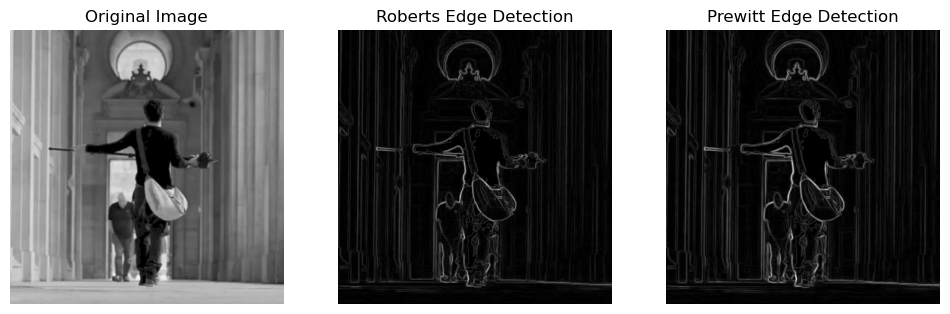

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def apply_filter(image, kernel_x, kernel_y):
    """Manually applies a convolution filter (Roberts or Prewitt)."""
    h, w = image.shape
    output = np.zeros((h-1, w-1))  # Reduce size as kernel is applied

    for i in range(h-1):  # Loop over each pixel (excluding last row/column)
        for j in range(w-1):
            # Extract the region for kernel multiplication
            region = image[i:i+2, j:j+2]  # For Roberts, 2x2 window
            gx = np.sum(region * kernel_x)
            gy = np.sum(region * kernel_y)
            output[i, j] = np.sqrt(gx**2 + gy**2)  # Gradient magnitude

    # Normalize the output
    output = (output / output.max()) * 255
    return output.astype(np.uint8)

# Load image and convert to grayscale
image = cv2.imread(r"C:\Users\srima\OneDrive\Documents\bunny.png", cv2.IMREAD_GRAYSCALE)  # Replace "sample.jpg" with your image

# --- Roberts Cross Operator ---
roberts_x = np.array([[1, 0], [0, -1]])
roberts_y = np.array([[0, 1], [-1, 0]])

roberts_result = apply_filter(image, roberts_x, roberts_y)

# --- Prewitt Operator (3x3 kernel) ---
def apply_prewitt(image, kernel_x, kernel_y):
    """Manually applies the Prewitt filter (3x3)."""
    h, w = image.shape
    output = np.zeros((h-2, w-2))  # Reduce size as kernel is applied

    for i in range(h-2):
        for j in range(w-2):
            region = image[i:i+3, j:j+3]  # 3x3 window
            gx = np.sum(region * kernel_x)
            gy = np.sum(region * kernel_y)
            output[i, j] = np.sqrt(gx**2 + gy**2)  # Gradient magnitude

    output = (output / output.max()) * 255
    return output.astype(np.uint8)

prewitt_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])  # Horizontal edges
prewitt_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])  # Vertical edges

prewitt_result = apply_prewitt(image, prewitt_x, prewitt_y)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(roberts_result, cmap="gray")
plt.title("Roberts Edge Detection")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(prewitt_result, cmap="gray")
plt.title("Prewitt Edge Detection")
plt.axis("off")

plt.show()


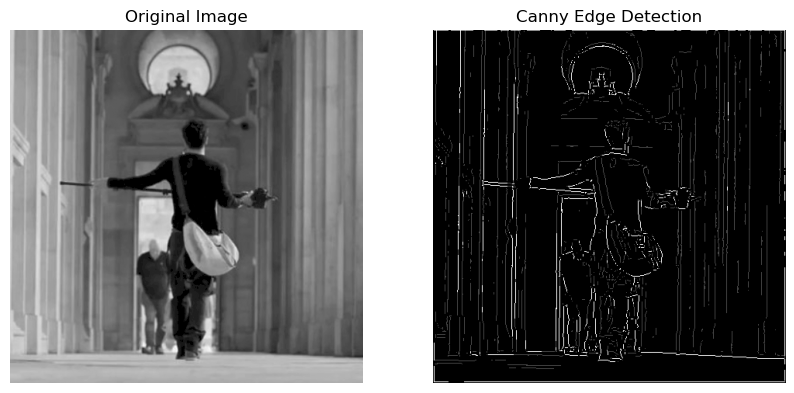

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def gaussian_blur(image, kernel_size=5, sigma=1.4):
    """Applies Gaussian blur to remove noise."""
    k = kernel_size // 2  # Kernel radius
    ax = np.linspace(-k, k, kernel_size)
    gauss_kernel = np.exp(-0.5 * (ax / sigma) ** 2)
    gauss_kernel = np.outer(gauss_kernel, gauss_kernel)  # 2D kernel
    gauss_kernel /= np.sum(gauss_kernel)  # Normalize

    h, w = image.shape
    output = np.zeros((h, w))

    for i in range(k, h-k):
        for j in range(k, w-k):
            region = image[i-k:i+k+1, j-k:j+k+1]  # Extract region
            output[i, j] = np.sum(region * gauss_kernel)  # Convolution

    return output.astype(np.uint8)

def sobel_gradient(image):
    """Computes Sobel gradient magnitude and direction."""
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    h, w = image.shape
    G_x = np.zeros((h-2, w-2))
    G_y = np.zeros((h-2, w-2))
    G = np.zeros((h-2, w-2))
    theta = np.zeros((h-2, w-2))

    for i in range(h-2):
        for j in range(w-2):
            region = image[i:i+3, j:j+3]
            G_x[i, j] = np.sum(region * sobel_x)
            G_y[i, j] = np.sum(region * sobel_y)
            G[i, j] = np.sqrt(G_x[i, j]**2 + G_y[i, j]**2)
            theta[i, j] = np.arctan2(G_y[i, j], G_x[i, j])  # Gradient direction

    return G, theta

def non_maximum_suppression(G, theta):
    """Applies Non-Maximum Suppression to thin edges."""
    h, w = G.shape
    output = np.zeros((h, w))

    angle = theta * (180.0 / np.pi)  # Convert radians to degrees
    angle[angle < 0] += 180  # Normalize angles

    for i in range(1, h-1):
        for j in range(1, w-1):
            q, r = 255, 255  # Default values

            # Define neighbors based on gradient direction
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                q, r = G[i, j+1], G[i, j-1]  # Horizontal neighbors
            elif (22.5 <= angle[i, j] < 67.5):
                q, r = G[i+1, j-1], G[i-1, j+1]  # Diagonal neighbors
            elif (67.5 <= angle[i, j] < 112.5):
                q, r = G[i+1, j], G[i-1, j]  # Vertical neighbors
            elif (112.5 <= angle[i, j] < 157.5):
                q, r = G[i-1, j-1], G[i+1, j+1]  # Diagonal neighbors

            # Suppress non-maximum edges
            if G[i, j] >= q and G[i, j] >= r:
                output[i, j] = G[i, j]
            else:
                output[i, j] = 0

    return output

def double_threshold(image, low, high):
    """Applies Double Thresholding."""
    strong = 255
    weak = 75

    strong_edges = image > high
    weak_edges = (image >= low) & (image <= high)

    output = np.zeros_like(image)
    output[strong_edges] = strong
    output[weak_edges] = weak

    return output

# Load image
image = cv2.imread(r"C:\Users\srima\OneDrive\Documents\bunny.png", cv2.IMREAD_GRAYSCALE)

# Apply Canny Edge Detection Steps
blurred = gaussian_blur(image)
G, theta = sobel_gradient(blurred)
thin_edges = non_maximum_suppression(G, theta)
edges = double_threshold(thin_edges, 40, 100)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap="gray")
plt.title("Canny Edge Detection")
plt.axis("off")

plt.show()
